In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, get_last_iteration_dir, last_tune_log, tune, Verbosity
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "023"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [16]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 4000  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.qwen_7b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 20  # 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 12  # 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 25  # 64
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-7B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 02-21 00:05:24 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 00:05:25 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 00:05:25 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.17s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.44s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.40s/it]



INFO 02-21 00:06:04 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-21 00:06:05 worker.py:267] Memory profiling takes 1.11 seconds
INFO 02-21 00:06:05 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 00:06:05 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 5.65GiB; the rest of the memory reserved for KV Cache is 55.08GiB.
INFO 02-21 00:06:05 executor_base.py:110] # CUDA blocks: 32228, # CPU blocks: 46811
INFO 02-21 00:06:05 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 62.95x
INFO 02-21 00:06:51 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.53 seconds
INFO 02-21 00:06:53 api_server.py:756] Using supplied chat template:
INFO 02-21 00:06:53 api_server.py:756] None
INFO 02-21 00:06:53 launcher.py:21] Available routes are:
INFO 02-21 00:06:53 launcher.py:29] Route: /

INFO:     Started server process [8094]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 00:06:58 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42424 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/500 [00:00<?, ?it/s]

val: 100%|██████████| 64/64 [21:34<00:00, 59.93s/it, completion_tokens=9436, prompt_tokens=1.2e+3, reward=0.0556, token_logprobs=603905]


Token indices sequence length is longer than the specified maximum sequence length for this model (16397 > 16384). Running this sequence through the model will result in indexing errors


train:  99%|█████████▉| 497/500 [33:30<00:19,  6.46s/it, completion_tokens=7862, prompt_tokens=1.46e+3, reward=0.0191, token_logprobs=3907346, exceptions=3]


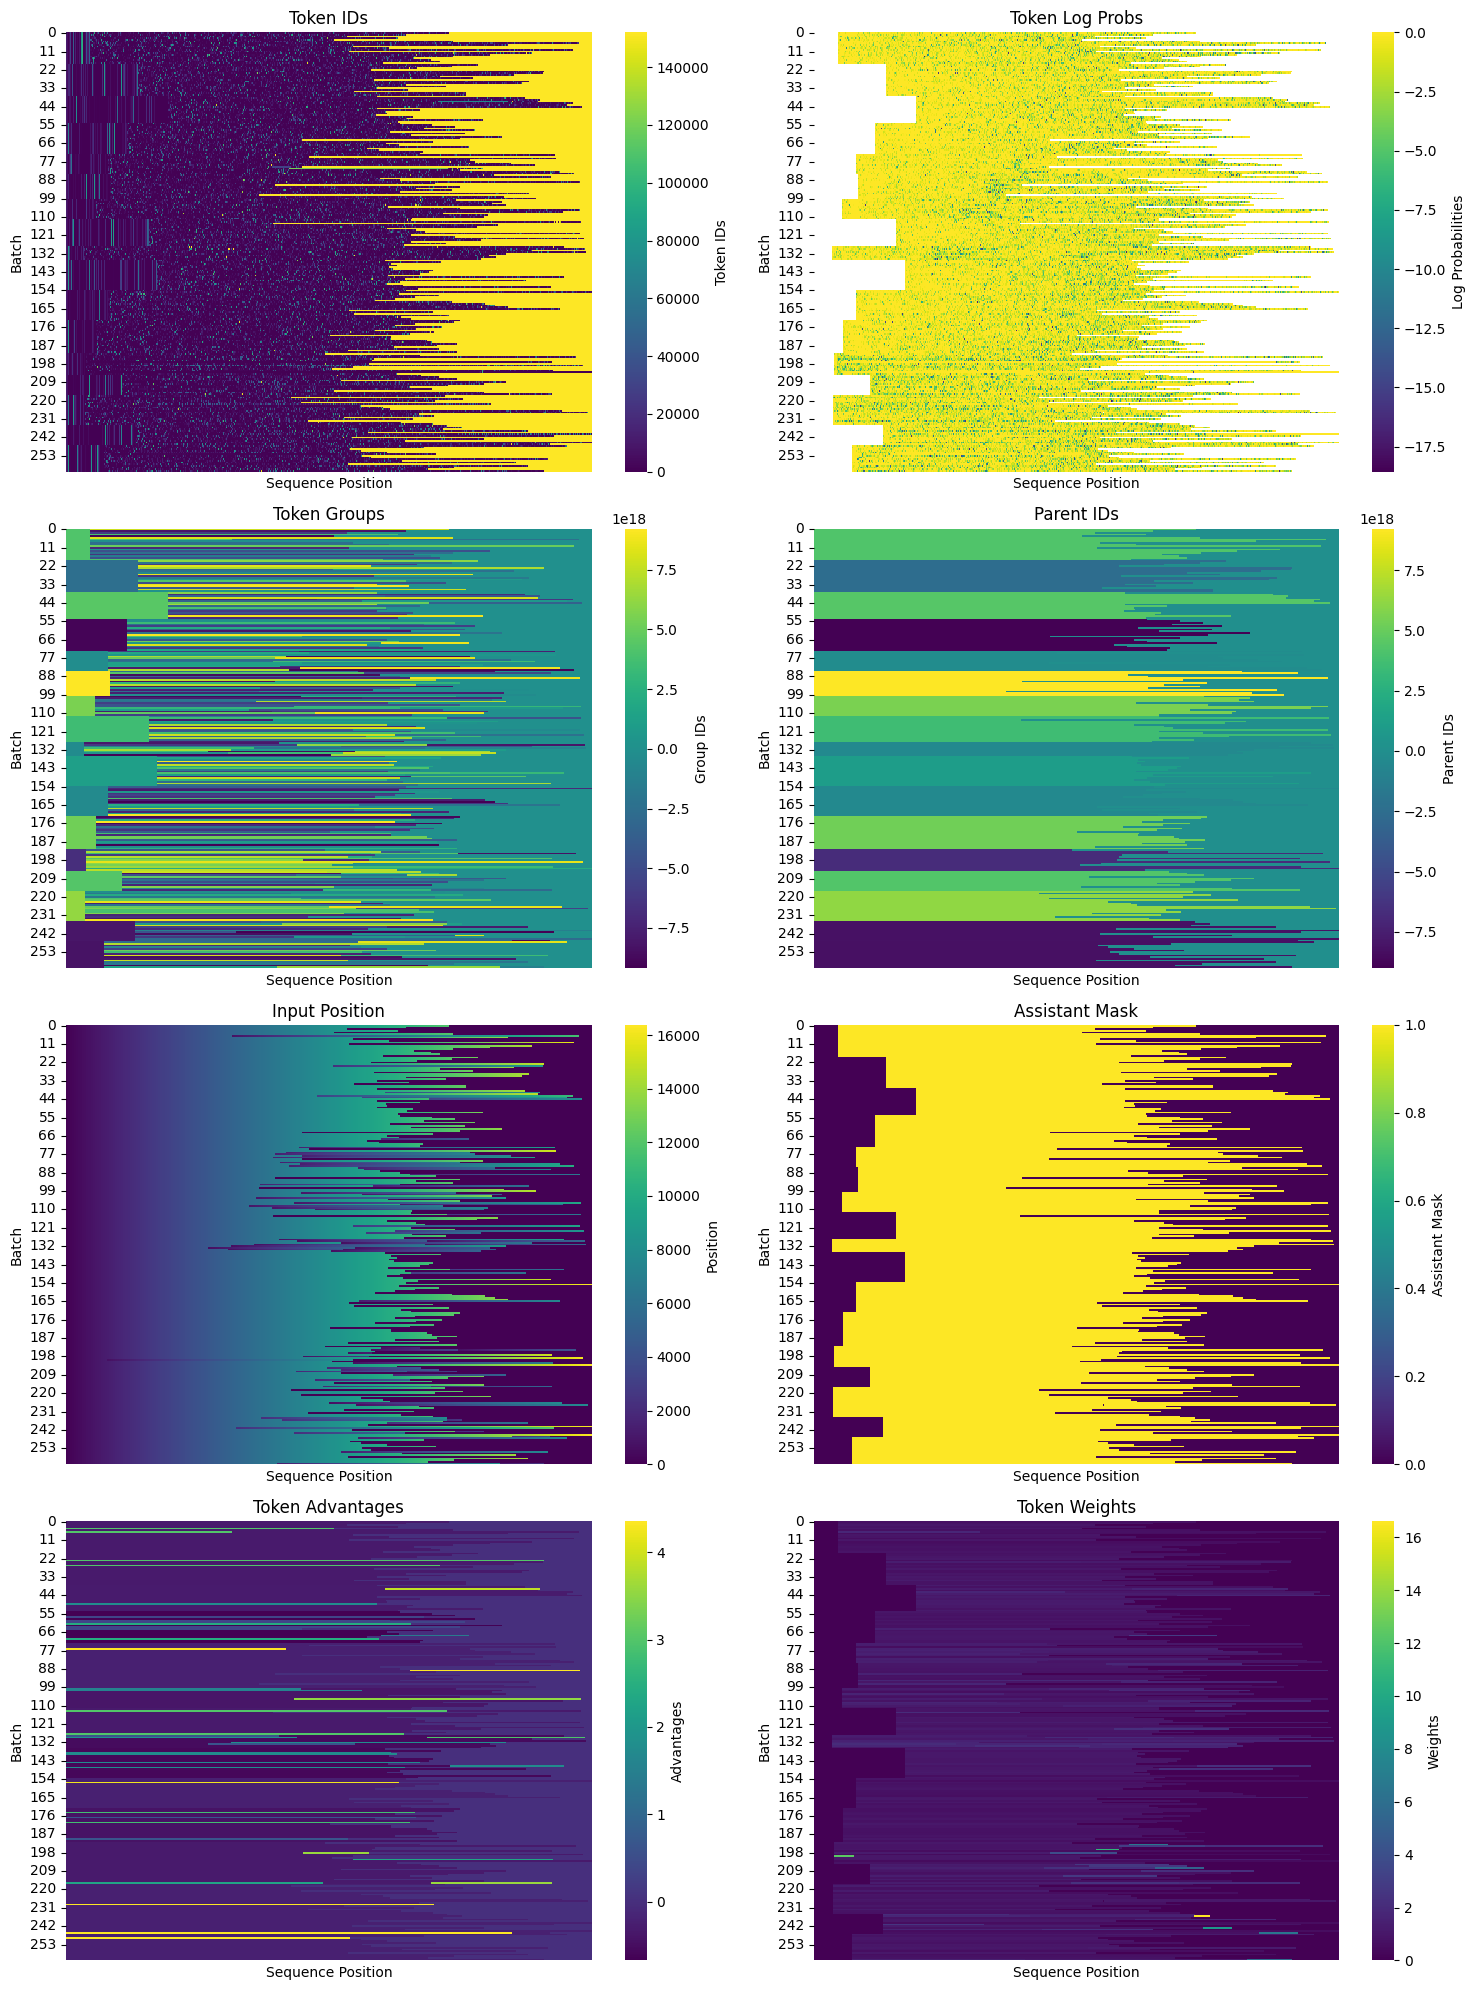

Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d42fae903e9fa07f3e8edb0db00a8d905ba49560
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d6ff9c6d4933688f95f315e3ce08f8e5e28eaeee
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/blobs/d1fd67ec1bf748c24b244b6efd825ded1b147787
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/023/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - model-00002-of-000002.safetensors
  - model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/023
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/023/tensors
  num_sequences: 263
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0


Writing logs to models/023/logs/log_1740098494.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 27.55 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|131|Loss: 0.2763: 100%|██████████| 131/131 [44:27<00:00, 20.30s/it, entropy=3.07, kl_div=nan, loss=0.276, policy=0.276]      INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.29 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB s

Saved iteration #1 model files to ./models/023/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/023/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/023/0001 --port=8000 --api-key=default
INFO 02-21 01:27:13 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 01:27:15 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 01:27:15 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/023/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:06<00:06,  6.72s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:11<00:00,  5.76s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:11<00:00,  5.91s/it]



INFO 02-21 01:27:43 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-21 01:27:44 worker.py:267] Memory profiling takes 0.89 seconds
INFO 02-21 01:27:44 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 01:27:44 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 5.65GiB; the rest of the memory reserved for KV Cache is 55.08GiB.
INFO 02-21 01:27:45 executor_base.py:110] # CUDA blocks: 32228, # CPU blocks: 46811
INFO 02-21 01:27:45 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 62.95x
INFO 02-21 01:28:26 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 42.69 seconds
INFO 02-21 01:28:28 api_server.py:756] Using supplied chat template:
INFO 02-21 01:28:28 api_server.py:756] None
INFO 02-21 01:28:28 launcher.py:21] Available routes are:
INFO 02-21 01:28:28 launcher.py:29] Route: /

INFO:     Started server process [11783]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 01:28:30 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:49500 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/500 [00:00<?, ?it/s]

train: 100%|██████████| 500/500 [37:24<00:00, 13.56s/it, completion_tokens=9139, prompt_tokens=1635.48, reward=0.0208, token_logprobs=4569332]


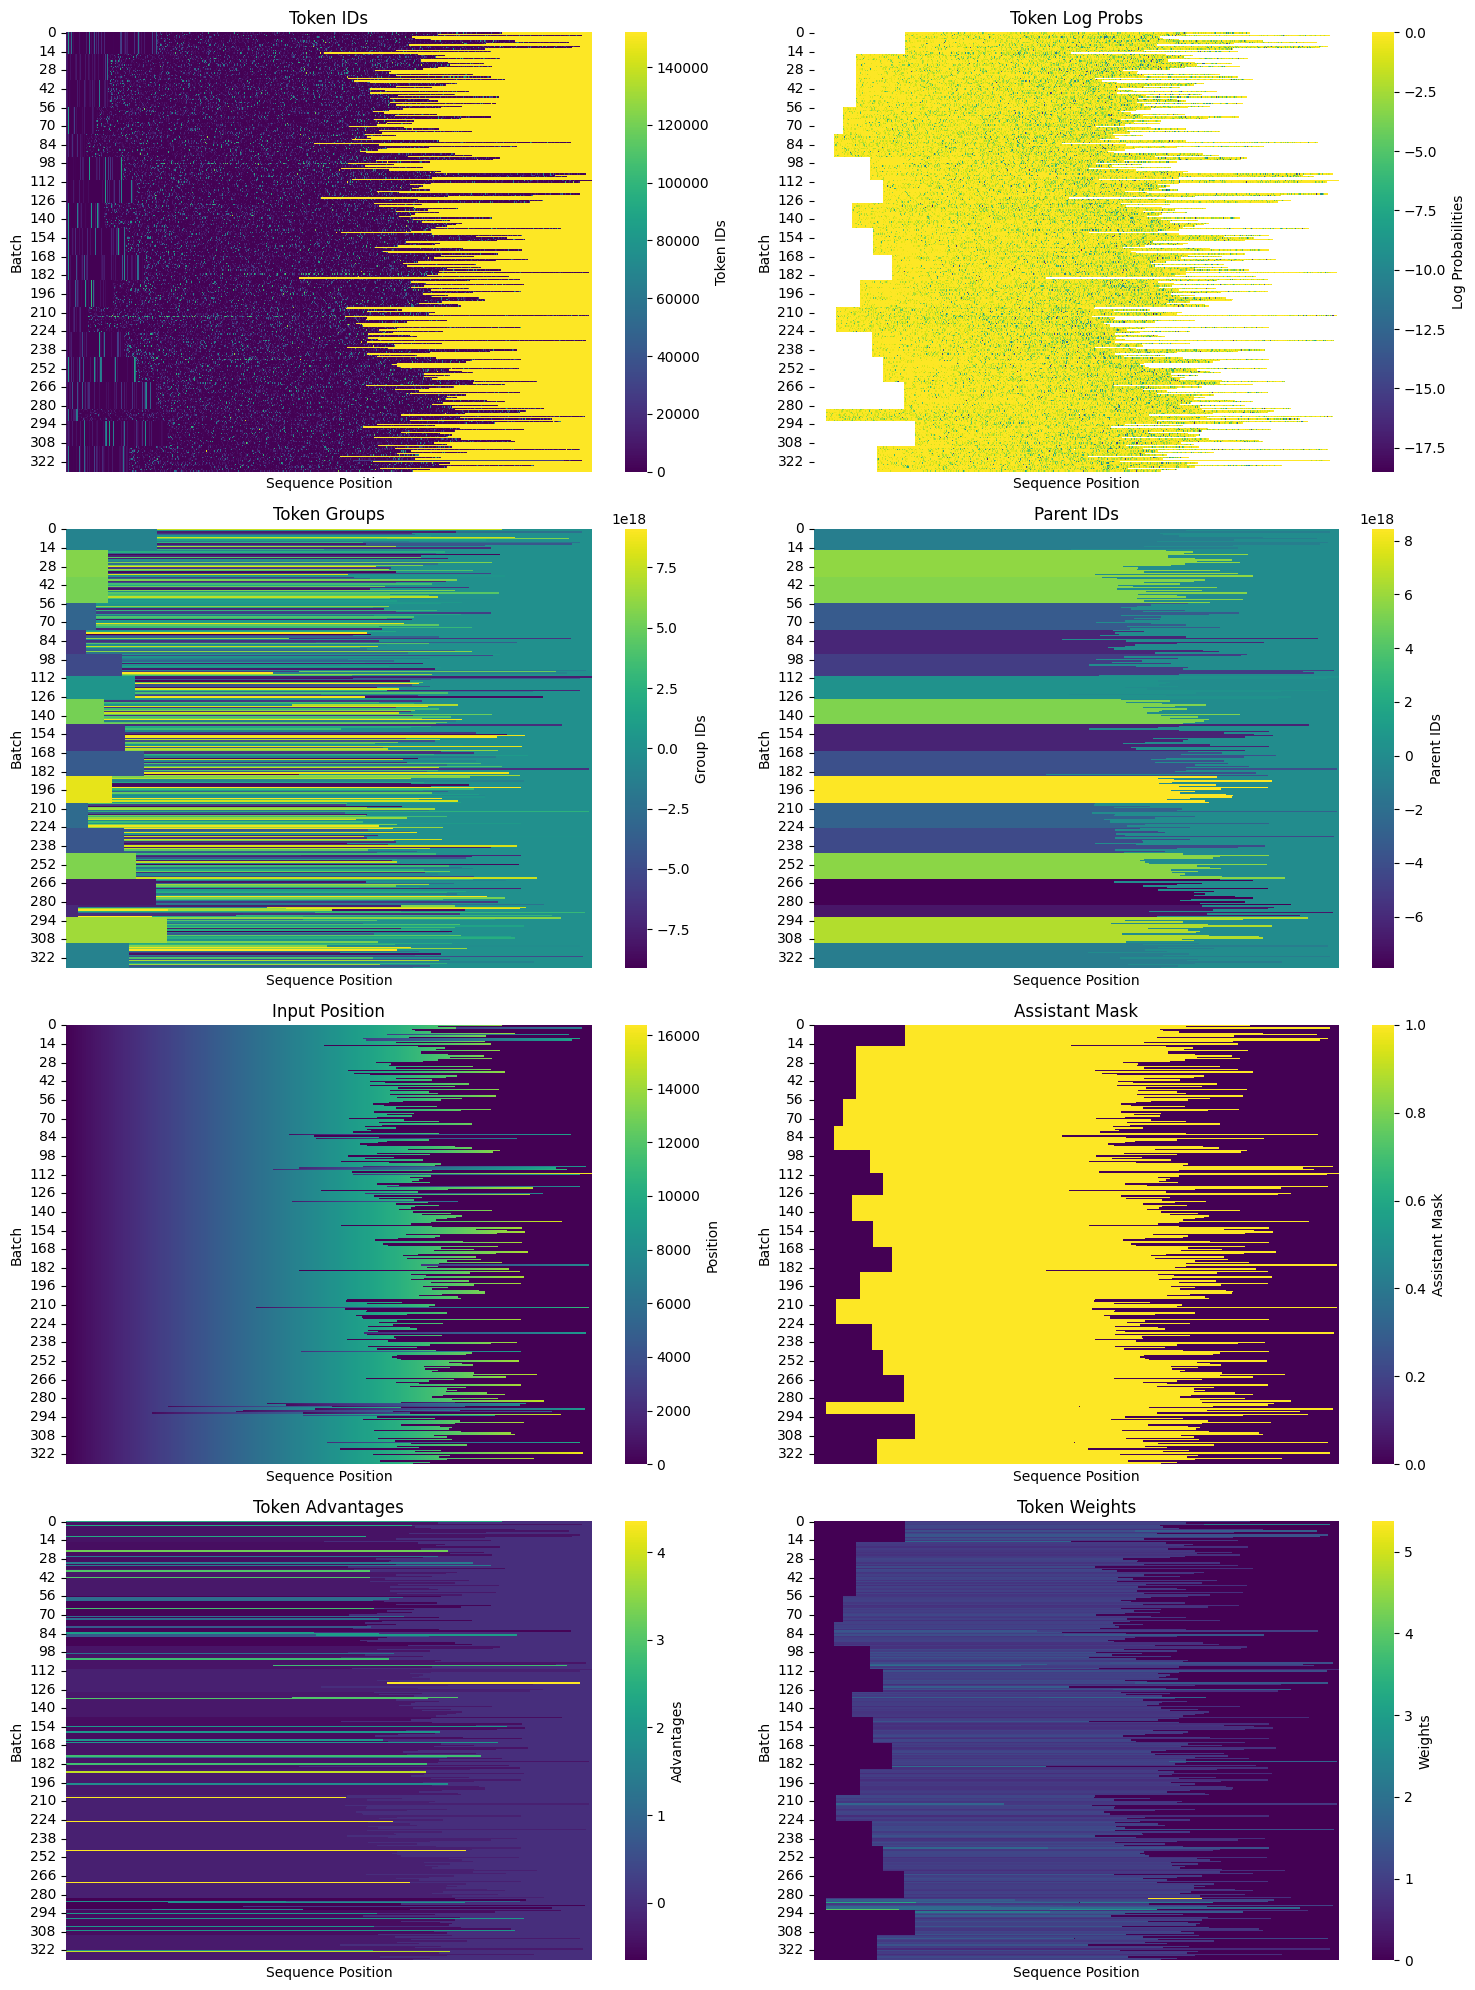

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/023/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/023/0001
  checkpoint_files:
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: QWEN2
  output_dir: ./models/023
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/023/tensors
  num_sequences: 330
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_logging.DiskLogger
  log_dir: ./models/023

Writing logs to models/023/logs/log_1740103636.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.53 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|165|Loss: -0.2078: 100%|██████████| 165/165 [56:05<00:00, 20.37s/it, entropy=3.05, kl_div=nan, loss=-0.208, policy=-0.208]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.28 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved

Saved iteration #2 model files to ./models/023/0002
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/023/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/023/0002 --port=8000 --api-key=default
INFO 02-21 03:04:26 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:04:27 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:04:27 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/023/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:04<00:04,  4.02s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.64s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.55s/it]



INFO 02-21 03:04:51 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-21 03:04:53 worker.py:267] Memory profiling takes 0.94 seconds
INFO 02-21 03:04:53 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:04:53 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 5.65GiB; the rest of the memory reserved for KV Cache is 55.08GiB.
INFO 02-21 03:04:53 executor_base.py:110] # CUDA blocks: 32228, # CPU blocks: 46811
INFO 02-21 03:04:53 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 62.95x
INFO 02-21 03:05:33 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 41.50 seconds
INFO 02-21 03:05:34 api_server.py:756] Using supplied chat template:
INFO 02-21 03:05:34 api_server.py:756] None
INFO 02-21 03:05:34 launcher.py:21] Available routes are:
INFO 02-21 03:05:34 launcher.py:29] Route: /

INFO:     Started server process [13346]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 03:05:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:56794 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/500 [00:00<?, ?it/s]

train: 100%|██████████| 500/500 [37:35<00:00,  8.48s/it, completion_tokens=9009, prompt_tokens=1649.92, reward=0.0391, token_logprobs=4.5e+6]
Deleted iteration directory ./models/023/0001


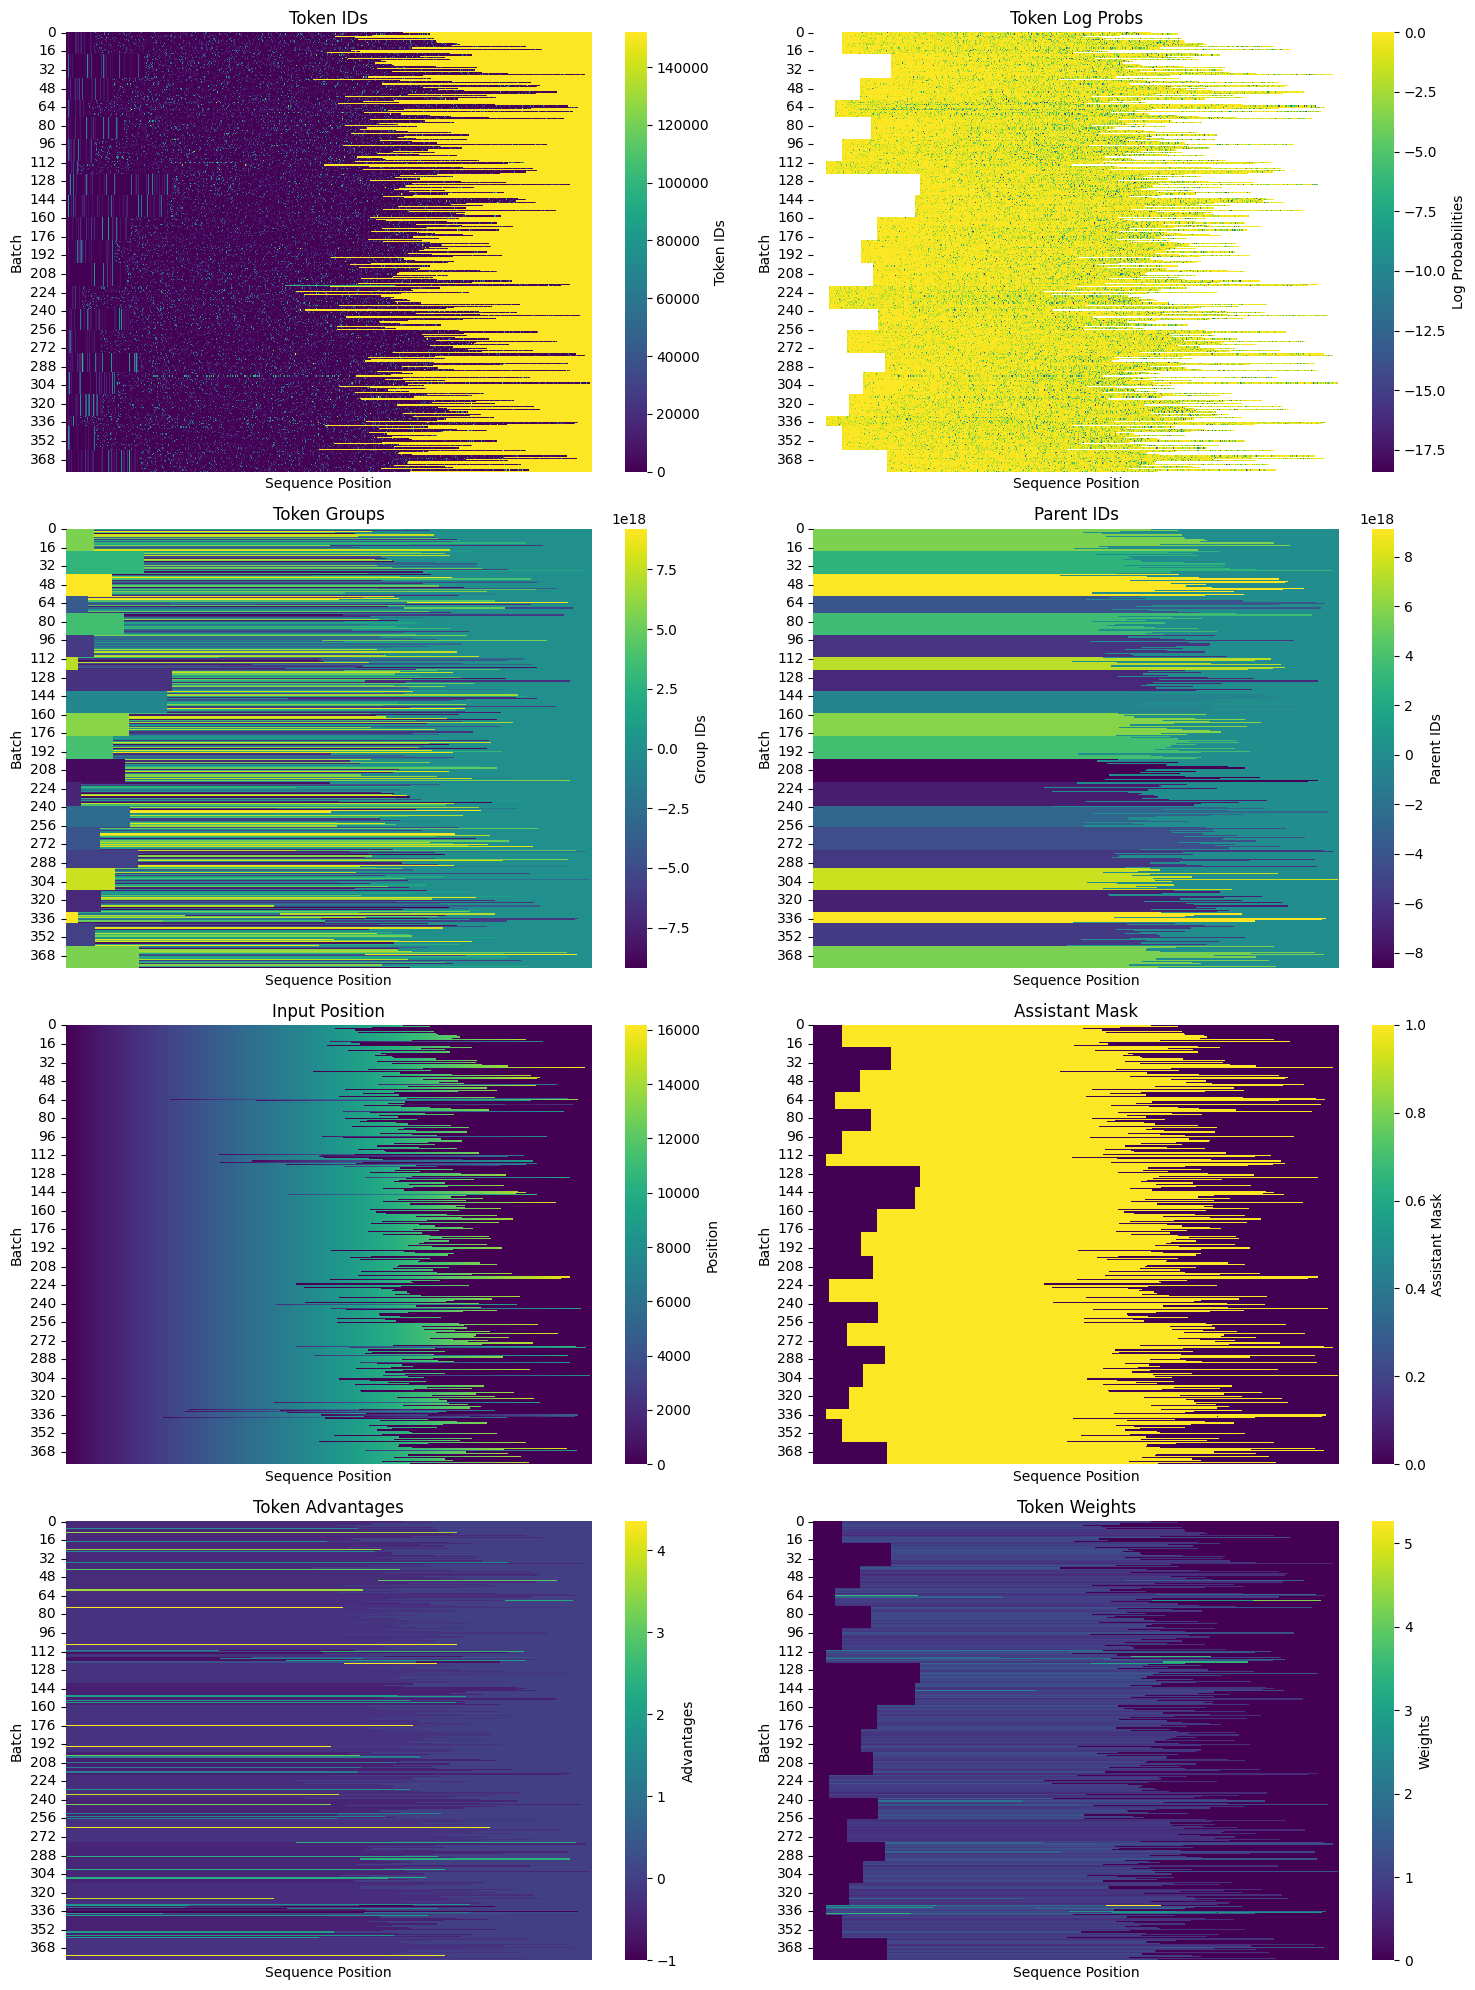

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/023/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/023/0002
  checkpoint_files:
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: QWEN2
  output_dir: ./models/023
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/023/tensors
  num_sequences: 379
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_logging.DiskLogger
  log_dir: ./models/023

Writing logs to models/023/logs/log_1740109486.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 21.04 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|2|Loss: -0.2452:   1%|          | 2/189 [00:51<1:17:40, 24.92s/it, entropy=3.1, kl_div=nan, loss=-0.245, policy=-0.245]

AssertionError: No model checkpoint files found to save in output directory ./models/023

In [17]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                }
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                }
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()